In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Load the data
movies_data = pd.read_csv('movies.csv')
ratings_data = pd.read_csv('ratings.csv')

# Display the first few rows of each dataset to understand their structure
movies_data.head(), ratings_data.head()

(   movieId                               title  \
 0        1                    Toy Story (1995)   
 1        2                      Jumanji (1995)   
 2        3             Grumpier Old Men (1995)   
 3        4            Waiting to Exhale (1995)   
 4        5  Father of the Bride Part II (1995)   
 
                                         genres  
 0  Adventure|Animation|Children|Comedy|Fantasy  
 1                   Adventure|Children|Fantasy  
 2                               Comedy|Romance  
 3                         Comedy|Drama|Romance  
 4                                       Comedy  ,
    userId  movieId  rating   timestamp
 0       1       16     4.0  1217897793
 1       1       24     1.5  1217895807
 2       1       32     4.0  1217896246
 3       1       47     4.0  1217896556
 4       1       50     4.0  1217896523)

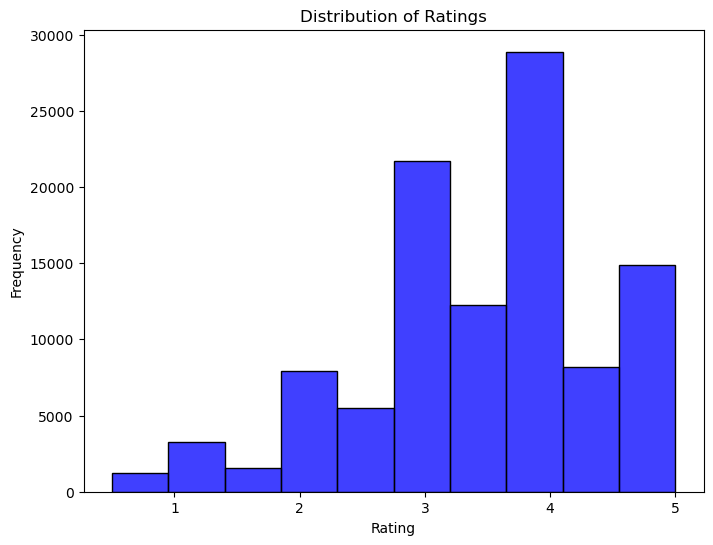

C:\Users\astra\AppData\Local\Temp\ipykernel_24572\938241250.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='viridis')


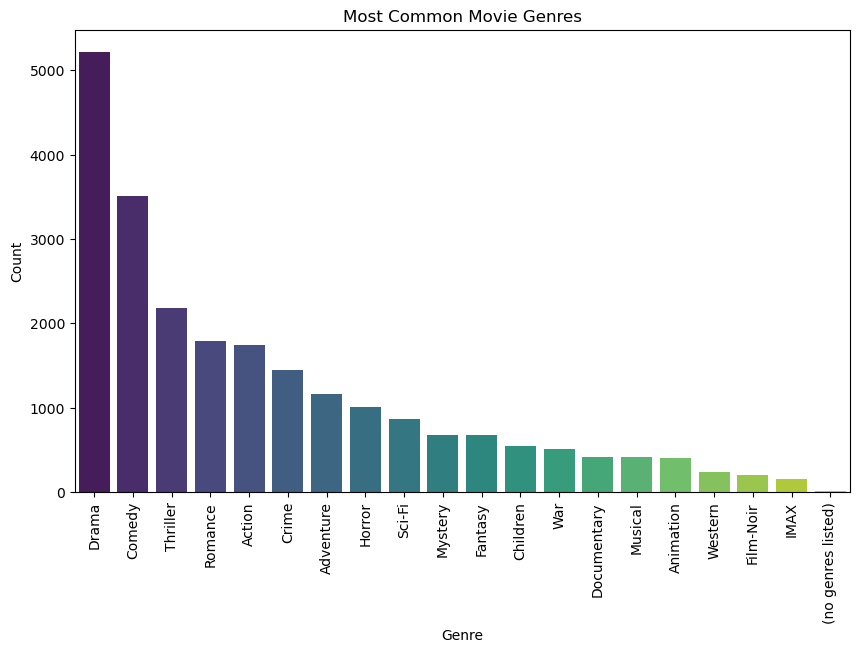

(movieId    0
 title      0
 genres     0
 dtype: int64,
 userId       0
 movieId      0
 rating       0
 timestamp    0
 dtype: int64,
               userId        movieId         rating     timestamp
 count  105339.000000  105339.000000  105339.000000  1.053390e+05
 mean      364.924539   13381.312477       3.516850  1.130424e+09
 std       197.486905   26170.456869       1.044872  1.802660e+08
 min         1.000000       1.000000       0.500000  8.285650e+08
 25%       192.000000    1073.000000       3.000000  9.711008e+08
 50%       383.000000    2497.000000       3.500000  1.115154e+09
 75%       557.000000    5991.000000       4.000000  1.275496e+09
 max       668.000000  149532.000000       5.000000  1.452405e+09)

In [10]:
# Step 1: Exploratory Data Analysis (EDA)

# Check for missing values in both datasets
movies_missing = movies_data.isnull().sum()
ratings_missing = ratings_data.isnull().sum()

# Descriptive statistics of the ratings data
ratings_stats = ratings_data.describe()

# Visualize the distribution of ratings
plt.figure(figsize=(8, 6))
sns.histplot(ratings_data['rating'], bins=10, kde=False, color='blue')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

# Analyze the most popular genres (extract genres from the movies dataset)
movies_data['genres'] = movies_data['genres'].str.split('|')
all_genres = movies_data['genres'].explode()

# Count the occurrence of each genre
genre_counts = all_genres.value_counts()

# Plot the most common genres
plt.figure(figsize=(10, 6))
sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='viridis')
plt.title('Most Common Movie Genres')
plt.xticks(rotation=90)
plt.xlabel('Genre')
plt.ylabel('Count')
plt.show()

movies_missing, ratings_missing, ratings_stats


In [13]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

# Step 1: Create a utility matrix with users as rows and movies as columns
ratings_pivot = ratings_data.pivot(index='userId', columns='movieId', values='rating').fillna(0)

# Convert the pivot table to a matrix format
ratings_matrix = ratings_pivot.values

# Step 2: Apply KNN for collaborative filtering (using cosine similarity)
knn = NearestNeighbors(metric='cosine', algorithm='brute')
knn.fit(ratings_matrix)

# Step 3: Test the model by finding the k-nearest neighbors for a user (e.g., user with index 0)
user_index = 0
distances, indices = knn.kneighbors([ratings_matrix[user_index]], n_neighbors=6)

# Output the indices and distances of the nearest neighbors
indices, distances


(array([[  0, 347, 505, 492, 157, 632]], dtype=int64),
 array([[2.22044605e-16, 5.86162326e-01, 5.88945957e-01, 5.93859556e-01,
         5.95675693e-01, 5.97271375e-01]]))

In [15]:
# Step 1: Get the movies that the selected user (user_index) has already rated
user_rated_movies = ratings_pivot.iloc[user_index, :]
user_rated_movies = user_rated_movies[user_rated_movies > 0].index.tolist()

# Step 2: For each neighbor, get the movies they have rated but the selected user hasn't rated
recommended_movies = []
neighbor_indices = indices.flatten()[1:]  # Exclude the first user (the user itself)

for neighbor_index in neighbor_indices:
    neighbor_rated_movies = ratings_pivot.iloc[neighbor_index, :]
    neighbor_rated_movies = neighbor_rated_movies[neighbor_rated_movies > 0].index.tolist()
    
    # Get the movies the neighbor rated but the user hasn't
    neighbor_recommended_movies = [movie for movie in neighbor_rated_movies if movie not in user_rated_movies]
    recommended_movies.extend(neighbor_recommended_movies)

# Step 3: Get the most frequent recommended movies
from collections import Counter

recommended_movies_count = Counter(recommended_movies)
top_recommended_movies = recommended_movies_count.most_common(10)

# Step 4: Fetch movie titles for the recommendations
top_movie_ids = [movie_id for movie_id, _ in top_recommended_movies]
recommended_movie_titles = movies_data[movies_data['movieId'].isin(top_movie_ids)]['title']

# Display the recommended movie titles
recommended_movie_titles.tolist()


['Batman Forever (1995)',
 'Dumb & Dumber (Dumb and Dumber) (1994)',
 'Lion King, The (1994)',
 'Rock, The (1996)',
 'Indiana Jones and the Last Crusade (1989)',
 'Truman Show, The (1998)',
 'Good Will Hunting (1997)',
 'X-Men (2000)',
 'Memento (2000)',
 'Pirates of the Caribbean: The Curse of the Black Pearl (2003)']

In [19]:
# Step 1: Create a dictionary to map movieId to the column index in the pivot table
movie_id_to_col = {movie_id: idx for idx, movie_id in enumerate(ratings_pivot.columns)}

# Step 2: Get the true ratings from the test data for the selected user (user_index)
true_ratings = ratings_pivot.iloc[user_index, :]
true_ratings = true_ratings[true_ratings > 0]

# Step 3: For each movie that the user has rated, i will predict the rating based on neighbor's ratings
predicted_ratings = []

for movie_id in true_ratings.index:
    movie_col_index = movie_id_to_col[movie_id]
    
    # Get the ratings from the neighbors for this movie
    neighbor_ratings = ratings_pivot.iloc[neighbor_indices.flatten(), movie_col_index]
    
    # Only consider neighbors who rated the movie (non-zero ratings)
    neighbor_ratings = neighbor_ratings[neighbor_ratings > 0]
    
    if len(neighbor_ratings) > 0:
        # Predict the rating as the mean rating from the neighbors
        predicted_rating = neighbor_ratings.mean()
    else:
        # If no neighbors rated the movie, predict the average rating from all users
        predicted_rating = ratings_pivot.iloc[:, movie_col_index].mean()
    
    predicted_ratings.append(predicted_rating)

# Step 4: Calculate RMSE between true and predicted ratings
rmse = mean_squared_error(true_ratings, predicted_ratings, squared=False)

rmse


NameError: name 'mean_squared_error' is not defined